# Optimizing analysis parameters $L$ and $\epsilon^2$

### Reading data as before

In [1]:
import divand
using PyPlot

In [2]:
varname = "Salinity"
filename = "WOD-Salinity-Provencal.nc"


if !isfile(filename)    
    download("https://b2drop.eudat.eu/s/UsF3RyU3xB1UM2o/download",filename)
end

value,lon,lat,depth,obstime,ids = divand.loadobs(Float64,filename,"Salinity");

})(Any) in module Vocab at C:\Users\jmbeckers\.julia\v0.6\divand\src\Vocab.jl:22 overwritten at C:\Users\jmbeckers\.julia\v0.6\divand\src\Vocab.jl:46.


### Topography and grid definition

See other notebook for explanation. Here just code replicated to get topography defining the mask.

In [3]:
dx = dy = 0.125/2.
lonr = 2.5:dx:12.
latr = 42.3:dy:44.6

mask,(pm,pn),(xi,yi) = divand.divand_rectdom(lonr,latr)

bathname = "gebco_30sec_4.nc"




if !isfile(bathname)
    download("https://b2drop.eudat.eu/s/ACcxUEZZi6a4ziR/download",bathname)
else
    info("Bathymetry file already downloaded")
end


bx,by,b = divand.load_bath(bathname,true,lonr,latr)



mask = falses(size(b,1),size(b,2))


    for j = 1:size(b,2)
        for i = 1:size(b,1)
        mask[i,j] = b[i,j] >=1.0
        end
    end


INFO: Bathymetry file already downloaded


### Data selection for example

Cross validation, error calculations etc. assume independant data. Hence do not take high-resolution vertical profiles with all data but restrict yourself to specific small depth ranges. Here August data at surface:

In [4]:
sel = (depth .< 1) .& (Dates.month.(obstime) .== 8)

value = value[sel]
lon = lon[sel]
lat = lat[sel]
depth = depth[sel]
obstime = obstime[sel]
ids = ids[sel];
@show (size(value))
divand.checkobs((lon,lat,depth,obstime),value,ids)

size(value) = (1956,)
              minimum and maximum of obs. dimension 1: (3.0763332843780518, 11.779999732971191)
              minimum and maximum of obs. dimension 2: (42.0, 44.0)
              minimum and maximum of obs. dimension 3: (0.0, 0.9921539425849915)
              minimum and maximum of obs. dimension 4: (1910-08-09T00:00:00, 2014-08-28T19:36:00)
                          minimum and maximum of data: (24.886999130249023, 39.18000030517578)


### Analysis

Analysis parameters have been calibrated in the other notebook example. 

Analysis fi using mean data as background. Structure s is stored for later use

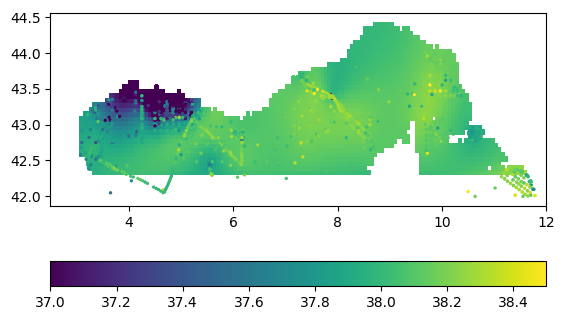

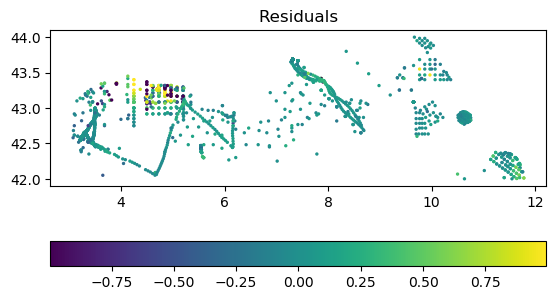

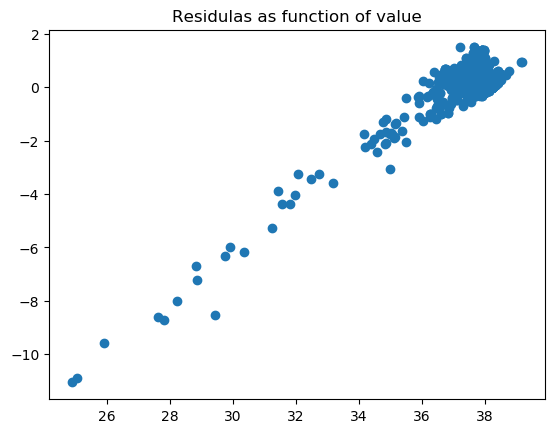

In [5]:
figure()

len=0.5
epsilon2=5
fi,s = divand.divandrun(mask,(pm,pn),(xi,yi),(lon,lat),value-mean(value),len,epsilon2);

pcolor(xi,yi,fi+mean(value),vmin=37,vmax=38.5);colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
dataresiduals=divand.divand_residualobs(s,fi)
scatter(lon,lat,s=2,c=value,vmin=37,vmax=38.5)




rscale=sqrt(var(value))

figure()
scatter(lon,lat,s=2,c=dataresiduals,vmin=-rscale,vmax=rscale);colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
title("Residuals")


figure()
scatter(value,dataresiduals)
title("Residulas as function of value");


# Cross validation

Take out data and measure difference between these data points not used and the analysis. Three methods are implemented 
# Define method used
    # 1: full CV
    # 2: sampled CV
    # 3: GCV
    # 0: automatic choice between the three possible ones, default value


(bestfactorl, bestfactore) = (0.5604945945336332, 0.7220569101343778)
(bestfactorl, bestfactore) = (0.5604945945336332, 0.647781545640427)
(bestfactorl, bestfactore) = (0.5213661814728049, 0.5213661814728049)


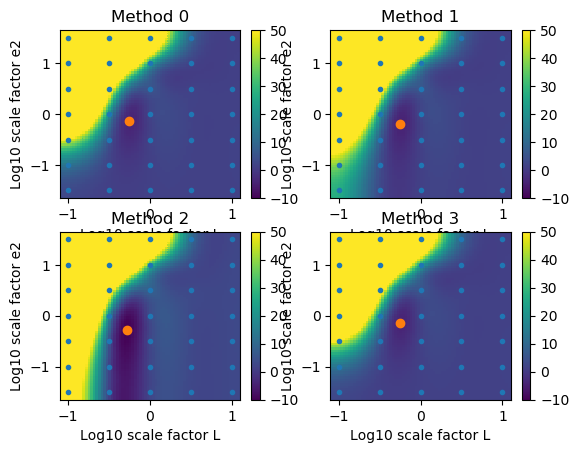

(bestfactorl, bestfactore) = (0.5604945945336332, 0.7220569101343778)


In [6]:
bestfactorl=1
bestfactore=1
for imeth=0:3

    bestfactorl,bestfactore, cvval,cvvalues, x2Ddata,y2Ddata,cvinter,xi2D,yi2D = divand.divand_cv(mask,(pm,pn),(xi,yi),(lon,lat),value,len,epsilon2,2,3,imeth);
    @show bestfactorl,bestfactore
    
    subplot(2,2,imeth+1)
    pcolor(xi2D,yi2D,cvinter,vmin=-10,vmax=50)
    colorbar()
    xlabel("Log10 scale factor L")
    ylabel("Log10 scale factor e2")
    plot(x2Ddata,y2Ddata,".")
    plot(log10.(bestfactorl), log10.(bestfactore),"o")
    title("Method $imeth")
end

WARNING: any tests with resulting length scales being smaller than around 4 times the grid spacing are meaningless.

Analysis with optimized values:


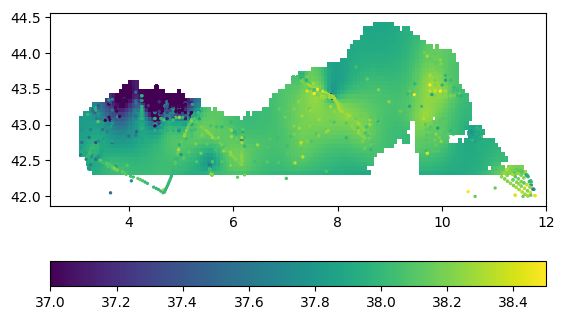

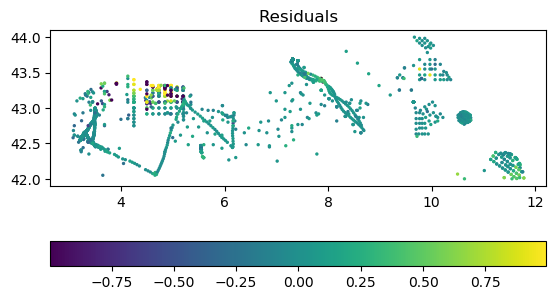

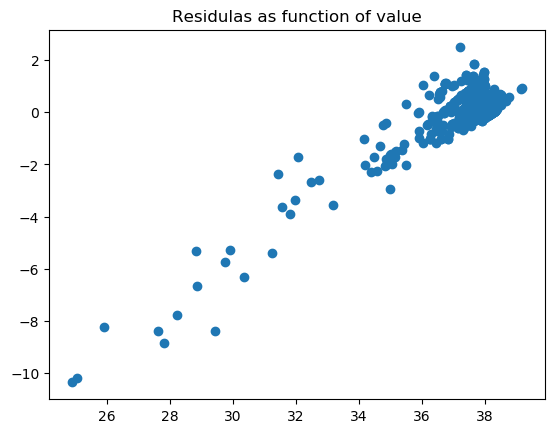

In [7]:
newl=len*bestfactorl
newe=epsilon2*bestfactore

fi,s = divand.divandrun(mask,(pm,pn),(xi,yi),(lon,lat),value-mean(value),newl,newe);

pcolor(xi,yi,fi+mean(value),vmin=37,vmax=38.5);colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
dataresiduals=divand.divand_residualobs(s,fi)
scatter(lon,lat,s=2,c=value,vmin=37,vmax=38.5)




rscale=sqrt(var(value))

figure()
scatter(lon,lat,s=2,c=dataresiduals,vmin=-rscale,vmax=rscale);colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
title("Residuals")


figure()
scatter(value,dataresiduals)
title("Residulas as function of value");


If $L$ is fixed by other calibration, you can decide to optimize only $\epsilon^2$:

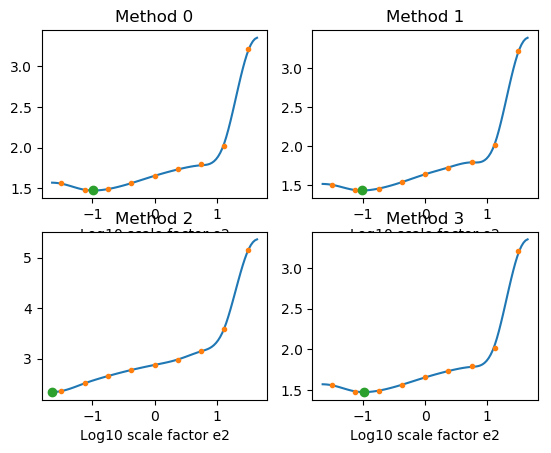

In [8]:
lenfixed=1
epsilon2=1
for imeth=0:3
    bestfactore, cvval,cvvalues, x2Ddata,cvinter,xi2D = divand.divand_cv(mask,(pm,pn),(xi,yi),(lon,lat),value-mean(value),lenfixed,epsilon2,0,4,imeth);

    subplot(2,2,imeth+1)
    plot(xi2D,cvinter,"-")
    xlabel("Log10 scale factor e2")
    plot(x2Ddata,cvvalues,".")
    plot(log10.(bestfactore), cvval,"o")
    title("Method $imeth")
end

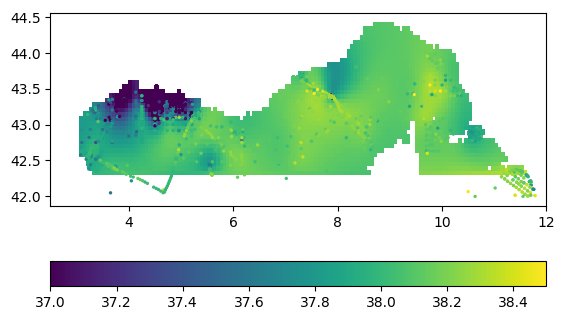

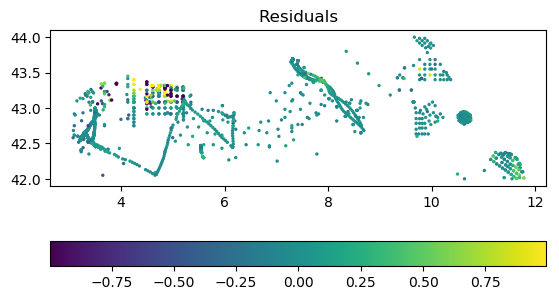

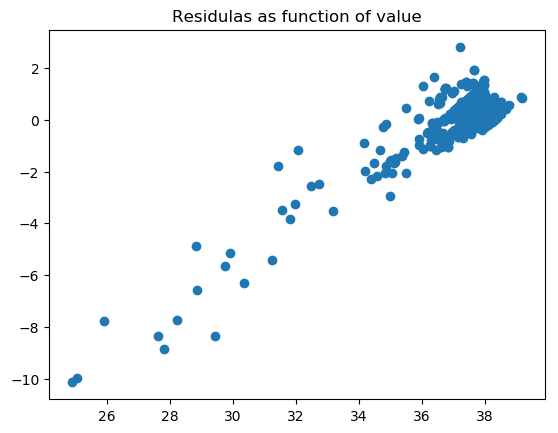

newe = 0.2686233317163645


In [15]:
newl=lenfixed
newe=epsilon2*bestfactore
@show newe
fi,s = divand.divandrun(mask,(pm,pn),(xi,yi),(lon,lat),value-mean(value),newl,newe);

pcolor(xi,yi,fi+mean(value),vmin=37,vmax=38.5);colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
dataresiduals=divand.divand_residualobs(s,fi)
scatter(lon,lat,s=2,c=value,vmin=37,vmax=38.5)




rscale=sqrt(var(value))

figure()
scatter(lon,lat,s=2,c=dataresiduals,vmin=-rscale,vmax=rscale);colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
title("Residuals")


figure()
scatter(value,dataresiduals)
title("Residulas as function of value");

Other method: adaptive method call with 0,0 points to sample in addition. De Rozier type of handling

In [17]:
cvbest2=zeros(20);
eps2=zeros(20)
lenfixed=1
epsilon2=1
for i=1:20
    cvval,factor=divand.divand_cv(mask,(pm,pn),(xi,yi),(lon,lat),value-mean(value),lenfixed,epsilon2,0,0,3);
    eps2[i]=epsilon2;
    cvbest2[i]=cvval;
    epsilon2=epsilon2*factor
    @show epsilon2
end



epsilon2 = 2.181199951004417
epsilon2 = 2.5393740108733476


epsilon2 = 2.6096885165301464
epsilon2 = 2.6223567312774745


epsilon2 = 2.624604149536049
epsilon2 = 2.625001765712755


epsilon2 = 2.625072078442963
epsilon2 = 2.625084511178682


epsilon2 = 2.625086709508602
epsilon2 = 2.625087098211616


epsilon2 = 2.6250871669410434
epsilon2 = 2.625087179093586


epsilon2 = 2.6250871812423133
epsilon2 = 2.625087181622324


epsilon2 = 2.6250871816894947


epsilon2 = 2.625087181701362
epsilon2 = 2.625087181703445


epsilon2 = 2.625087181703815
epsilon2 = 2.6250871817038814


epsilon2 = 2.62508718170391


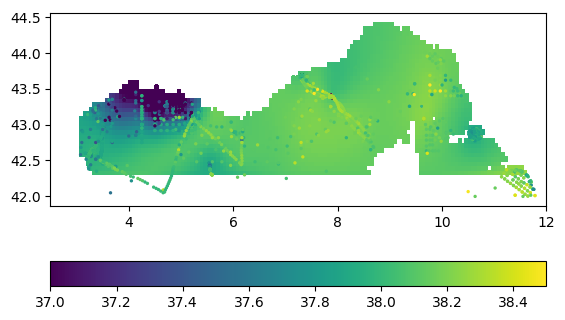

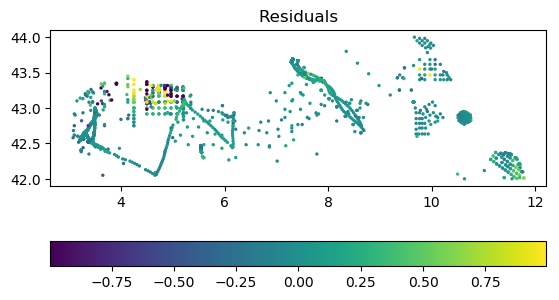

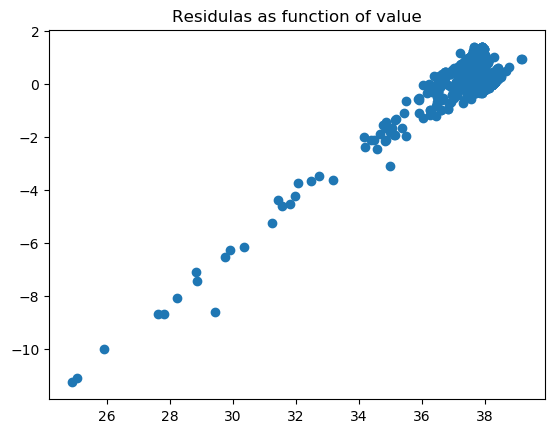

newe = 2.62508718170391


In [16]:
newl=lenfixed
newe=epsilon2
@show newe
fi,s = divand.divandrun(mask,(pm,pn),(xi,yi),(lon,lat),value-mean(value),newl,newe);

pcolor(xi,yi,fi+mean(value),vmin=37,vmax=38.5);colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
dataresiduals=divand.divand_residualobs(s,fi)
scatter(lon,lat,s=2,c=value,vmin=37,vmax=38.5)




rscale=sqrt(var(value))

figure()
scatter(lon,lat,s=2,c=dataresiduals,vmin=-rscale,vmax=rscale);colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
title("Residuals")


figure()
scatter(value,dataresiduals)
title("Residulas as function of value");

In [12]:
var(dataresiduals),var(value),var(fi[(fi.!==NaN)])

(0.46244257134706973, 0.990346699659609, 0.3727743912053822)

## More information

In [11]:
?divand.divand_cv

Compute a variational analysis of arbitrarily located observations to calculate an estimate of the optimal value of epsilon2

bestfactorl,bestfactore, cvval,cvvalues, x2Ddata,y2Ddata,cvinter,xi2D,yi2D = divand_cv(mask,pmn,xi,x,f,len,epsilon2,nl,ne,...);

Perform an n-dimensional variational analysis of the observations `f` located at the coordinates `x`. The output `factors` represent multipliction factors applied to epsilon2 which have been tested and the cvvalues the corresponding cross validation values.

The epsilon2 provided should be close the real one as the tests will be performed around

The analysus is defined by the coordinates `xi` and the scales factors `pmn`.

# Input:

  * `mask`: binary mask delimiting the domain. true is inside and false outside. For oceanographic application, this is the land-sea mask.
  * `pmn`: scale factor of the grid. pmn is a tuple with n elements. Every      element represents the scale factor of the corresponding dimension. Its      inverse is the local resolution of the grid in a particular dimension.
  * `xi`: tuple with n elements. Every element represents a coordinate of the final grid on which the observations are interpolated
  * `x`: tuple with n elements. Every element represents a coordinate of the observations
  * `f`: value of the observations *minus* the background estimate (m-by-1 array).   (see note)
  * `len`: correlation length
  * `epsilon2`: error variance of the observations (normalized by the error variance of the background field). `epsilon2` can be a scalar (all observations have the same error variance and their errors are decorrelated), a vector (all observations can have a difference error variance and their errors are decorrelated) or a matrix (all observations can have a difference error variance and their errors can be correlated). If `epsilon2` is a scalar, it is thus the *inverse of the signal-to-noise ratio*.
  * `nl`: number of testing points around the current value of l. One means an addition point on both sides of the current L. Zero is allowed and means the parameter is not optimised.
  * `ne`: number of testing points around the current value of epsilon2. Zero is allowed as for nl

# Optional input arguments specified as keyword arguments also as for divand

# Output:

  * `bestfactorl`: best estimate of the multipliocation factor to apply to len
  * `bestfactore`: best estimate of the multipliocation factor to apply to epsilon2
  * `cvvales` : the cross validation values calculated
  * `factors` : the tested multiplication factors
  * `cvinter` : interpolated cv values for final optimisation
  * `linter` : values of the factors at which the interpolation was done (in log scale)
  * `epsilon2inter` : values of the factors at which the interpolation was done (in log scale)


# Exercise

* Redo for different data.
* Possibly force the cross-validation method (use ?divand_cv)
* Once opimized, try to redo optimization with starting point being the first estimate+

# Remember: optimization relies on a series of hypotheses. In particular, data independance and isotropy is very often NOT ensured. When in doubt, increase $\epsilon^2$ and/or check for "duplicates".